In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install cellpose

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/211.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.

In [3]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage import io, color
from skimage.transform import resize

# Install Cellpose


# Cellpose imports
from cellpose import models, io as cellpose_io
from cellpose import metrics



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	linux 
python version: 	3.11.12 
torch version:  	2.6.0+cu124! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




Validation images shape: (55, 256, 256, 3)
Validation masks shape: (55, 256, 256, 1)


Cellpose Predicting: 100%|██████████| 55/55 [01:00<00:00,  1.10s/it]



--- Evaluating Cellpose on Validation Set ---
Validation IoU: 0.6972
Validation Dice Coefficient: 0.8166
Validation Precision: 0.8836
Validation Recall: 0.7747
Validation Accuracy: 0.8623

--- Visualizing Predictions on Validation Set ---


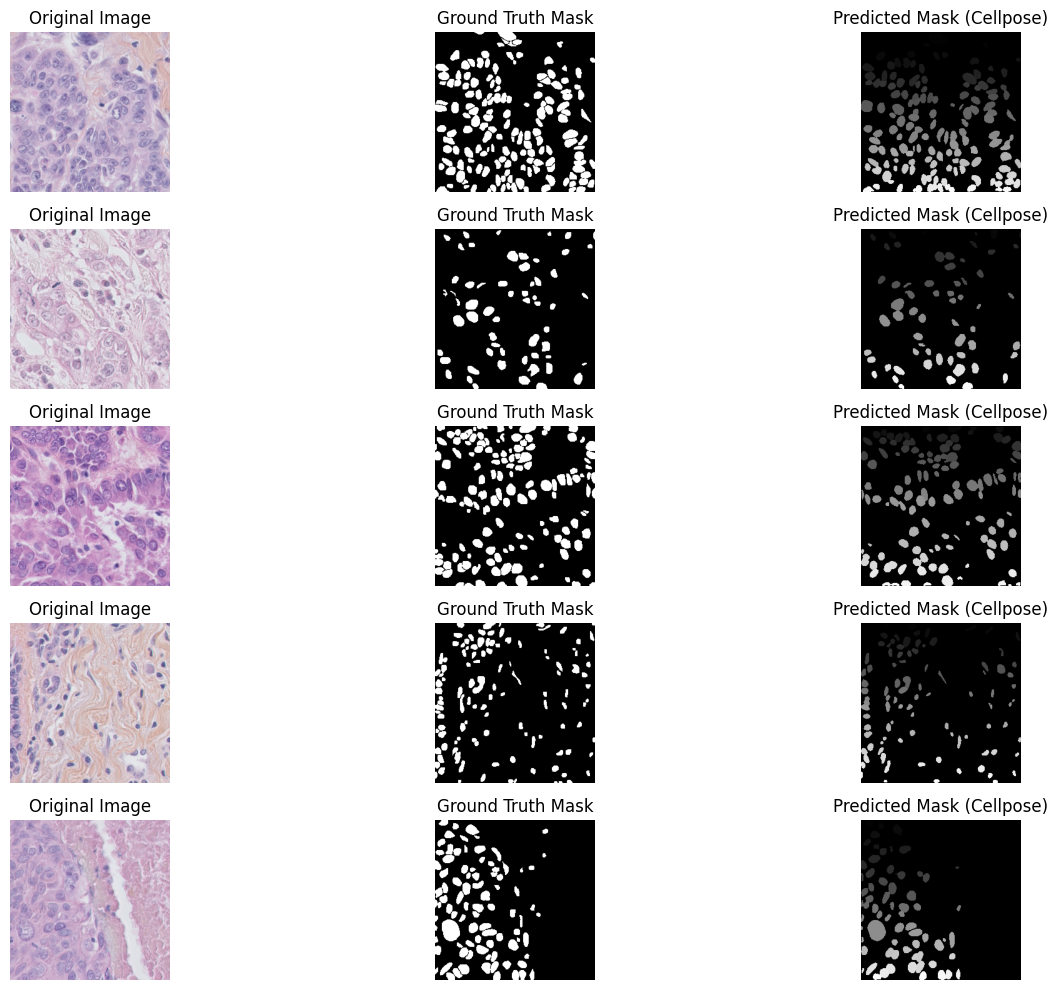

In [5]:
# --- Data Paths ---
DATA_DIR = '/content/drive/MyDrive/nuclei_dataset' # Adjust this to your main dataset directory
VAL_IMG_DIR = '/content/drive/MyDrive/NucleiSegmentation/TestDataset/images' # Adjust if you have a separate validation set
VAL_MASK_DIR = '/content/drive/MyDrive/NucleiSegmentation/TestDataset/masks' # Adjust if you have a separate validation set
# --- Data Paths ---
DATA_DIR = '/content/drive/MyDrive' # Adjust this to your main dataset directory
TRAIN_IMG_DIR = '/content/drive/MyDrive/NucleiSegmentation/NucleiSegmentationDataset/all_images'
TRAIN_MASK_DIR = '/content/drive/MyDrive/NucleiSegmentation/NucleiSegmentationDataset/merged_masks'

# --- Parameters ---
IMG_WIDTH = 256 # Cellpose can handle various sizes, but we'll resize for consistency in visualization
IMG_HEIGHT = 256
IMG_CHANNELS = 3 # Cellpose works best with RGB images
MODEL_TYPE = 'nuclei' # Pre-trained model for nuclei
CELLPOSE_CHANNEL = 0 # For grayscale images, use channel 0
CELLPOSE_GPU = True # Use GPU if available

# --- Helper Functions ---
def load_data(img_dir, mask_dir, img_height, img_width):
    images = []
    masks = []
    img_filenames = sorted(os.listdir(img_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(img_filenames, mask_filenames):
        if not img_file.startswith('.') and not mask_file.startswith('.'):
            img_path = os.path.join(img_dir, img_file)
            mask_path = os.path.join(mask_dir, mask_file)

            img = io.imread(img_path)
            mask = io.imread(mask_path)

            if img.ndim == 2:
                img = np.stack([img, img, img], axis=-1) # Convert grayscale to RGB
            elif img.ndim == 3 and img.shape[2] == 4:
                img = img[:, :, :3] # Drop alpha if RGBA

            if mask.ndim == 3:
                mask = color.rgb2gray(mask)

            img_resized = resize(img, (img_height, img_width), anti_aliasing=True).astype(np.float32)
            mask_resized = resize(mask, (img_height, img_width), anti_aliasing=True)
            mask_binary = (mask_resized > 0.5).astype(np.uint8) # Ensure binary mask
            mask_binary = np.expand_dims(mask_binary, axis=-1)

            images.append(img_resized)
            masks.append(mask_binary)

    return np.array(images), np.array(masks)

# Load validation data (adjust if you split training data)
if os.path.exists(VAL_IMG_DIR) and os.path.exists(VAL_MASK_DIR):
    X_val, Y_val = load_data(VAL_IMG_DIR, VAL_MASK_DIR, IMG_HEIGHT, IMG_WIDTH)
else:
    print("Validation data directories not found. Loading and splitting training data.")
    X_train_full, Y_train_full = load_data(TRAIN_IMG_DIR, TRAIN_MASK_DIR, IMG_HEIGHT, IMG_WIDTH)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train_full, Y_train_full, test_size=0.2, random_state=42)

print(f"Validation images shape: {X_val.shape}")
print(f"Validation masks shape: {Y_val.shape}")

# --- Load Cellpose Model ---
model = models.CellposeModel(gpu=CELLPOSE_GPU, model_type=MODEL_TYPE)

# --- Prediction with Cellpose ---
predictions = []
for img in tqdm(X_val, desc="Cellpose Predicting"):
    masks, _, _= model.eval(img, diameter=None, channels=[0, 0]) # Assuming grayscale converted to RGB, using first channel
    predictions.append(masks)
predictions = np.array(predictions)
predictions = np.expand_dims(predictions, axis=-1) # Add channel dimension

# --- Metrics ---
def iou_metric_np(y_true, y_pred):
    intersection = np.logical_and(y_true > 0.5, y_pred > 0.5).sum((1, 2, 3))
    union = np.logical_or(y_true > 0.5, y_pred > 0.5).sum((1, 2, 3))
    iou = (intersection + 1e-7) / (union + 1e-7)
    return np.mean(iou)

def dice_coef_np(y_true, y_pred):
    intersection = np.logical_and(y_true > 0.5, y_pred > 0.5).sum((1, 2, 3))
    union = (y_true > 0.5).sum((1, 2, 3)) + (y_pred > 0.5).sum((1, 2, 3))
    dice = (2. * intersection + 1e-7) / (union + 1e-7)
    return np.mean(dice)

def precision_metric_np(y_true, y_pred):
    true_positives = np.logical_and(y_true > 0.5, y_pred > 0.5).sum((1, 2, 3))
    predicted_positives = (y_pred > 0.5).sum((1, 2, 3))
    precision = (true_positives + 1e-7) / (predicted_positives + 1e-7)
    return np.mean(precision)

def recall_metric_np(y_true, y_pred):
    true_positives = np.logical_and(y_true > 0.5, y_pred > 0.5).sum((1, 2, 3))
    actual_positives = (y_true > 0.5).sum((1, 2, 3))
    recall = (true_positives + 1e-7) / (actual_positives + 1e-7)
    return np.mean(recall)

def accuracy_metric_np(y_true, y_pred):
    correct = (np.round(y_true) == np.round(y_pred)).astype(float).sum((1, 2, 3))
    total = np.prod(y_true.shape[1:])
    accuracy = np.mean(correct / total)
    return accuracy

# Evaluate the model
print("\n--- Evaluating Cellpose on Validation Set ---")
iou = iou_metric_np(Y_val, predictions)
dice = dice_coef_np(Y_val, predictions)
precision = precision_metric_np(Y_val, predictions)
recall = recall_metric_np(Y_val, predictions)
accuracy = accuracy_metric_np(Y_val, predictions)

print(f"Validation IoU: {iou:.4f}")
print(f"Validation Dice Coefficient: {dice:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# --- Visualize Predictions ---
print("\n--- Visualizing Predictions on Validation Set ---")
n_samples = 5
indices = np.random.choice(len(X_val), n_samples, replace=False)

plt.figure(figsize=(15, 10))
for i, index in enumerate(indices):
    img = X_val[index]
    mask = Y_val[index]
    pred_mask = predictions[index]

    plt.subplot(n_samples, 3, i * 3 + 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(n_samples, 3, i * 3 + 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(n_samples, 3, i * 3 + 3)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask (Cellpose)")
    plt.axis('off')

plt.tight_layout()
plt.show()